In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 5.18 s


In [4]:
%%time
# log records count and data frame/partitions stats
print('Chicago Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Chicago Crime data stats:
---------------------------------------
6,389,375 total records in 1 partitions
DataFrame size: 63,893,750
Wall time: 5.52 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude,Year
npartitions=1,,,,,,,,,,
2001-01-01 00:00:00,object,category[unknown],category[unknown],category[unknown],category[unknown],bool,bool,float64,float64,category[unknown]
2017-08-10 23:55:00,...,...,...,...,...,...,...,...,...,...


In [6]:
%%time
# preview crimes data with Date index
crimes.head(5)

Wall time: 4.01 ms


,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude,Year
Date,,,,,,,,,,
2001-01-01,048XX S KENWOOD AVE,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,39.0,False,False,41.807275,-87.593707,2001
2001-01-01,043XX S CAMPBELL AVE,DECEPTIVE PRACTICE,FINAN EXPLOIT-ELDERLY/DISABLED,RESIDENCE,58.0,False,False,41.815118,-87.686955,2001
2001-01-01,081XX S COLES AVE,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,46.0,False,False,41.746697,-87.549015,2001
2001-01-01,061XX S COTTAGE GROVE AV,THEFT,$500 AND UNDER,STREET,NaN,False,False,41.783962,-87.606155,2001
2001-01-01,041XX W 24 PL,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,NaN,False,False,41.847059,-87.727795,2001


In [7]:
%%time

# get crime types
crime_types = crimes[['PrimaryType']]

# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                     Arrest  Domestic    Total
PrimaryType                                                   
THEFT                              160904.0   30900.0  1333331
BATTERY                            267664.0  492971.0  1168774
CRIMINAL DAMAGE                     52161.0   55293.0   733734
NARCOTICS                          682821.0     245.0   687056
OTHER OFFENSE                       70068.0  115322.0   396693
ASSAULT                             92488.0   85185.0   392983
BURGLARY                            21325.0    2458.0   371699
MOTOR VEHICLE THEFT                 27746.0    1136.0   300692
ROBBERY                             23622.0    3897.0   242089
DECEPTIVE PRACTICE                  42619.0    2764.0   236109
CRIMINAL TRESPASS                  136684.0    5826.0   184557
PROSTITUTION                        66075.0       6.0    66335
WEAPONS VIOLATION                   51483.0     227.0    64018
PUBLIC PEACE VIOLATION              29578.0    2144.0  

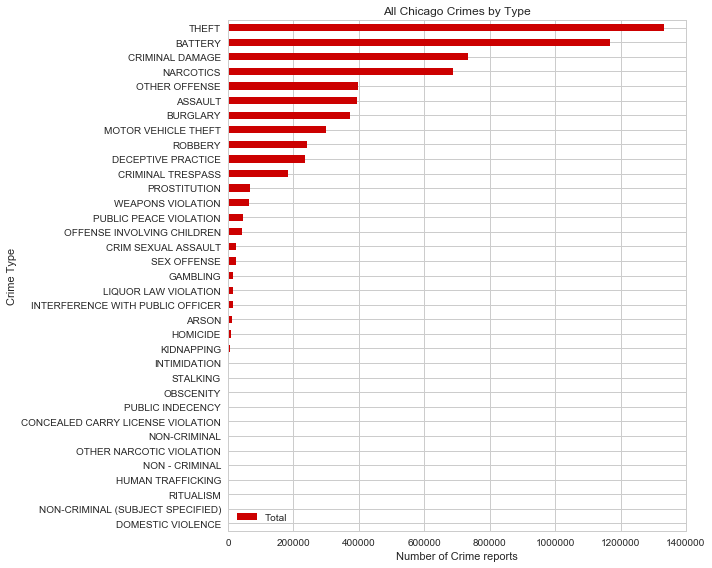

In [8]:
# plot crimes by primary type counts
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True)\
.drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('All Chicago Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

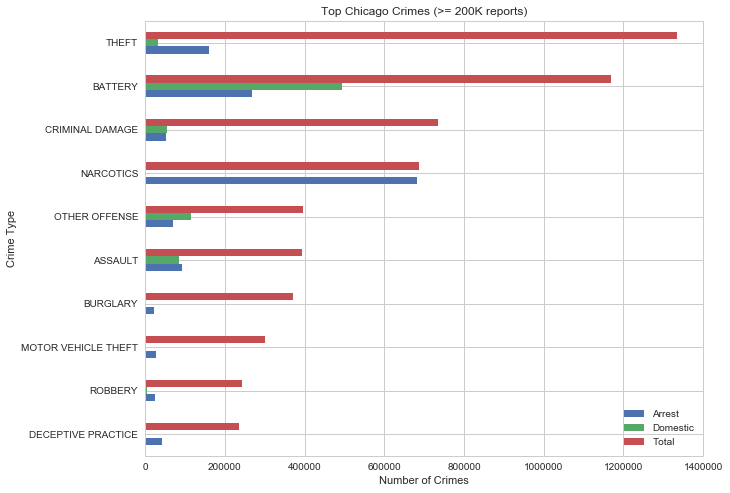

In [9]:
# plot top crimes (>-= 200,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.show()

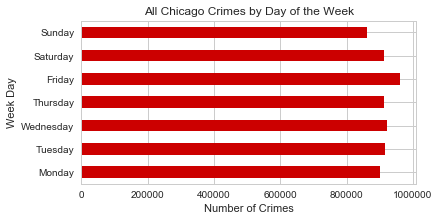

In [10]:
# plot crimes per day of the week
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().compute()\
.plot(kind='barh', figsize=(6,3), color='#cc0000')
plt.title('All Chicago Crimes by Day of the Week')
plt.xlabel('Number of Crimes')
plt.ylabel('Week Day')
plt.yticks(np.arange(7), days)
plt.show()

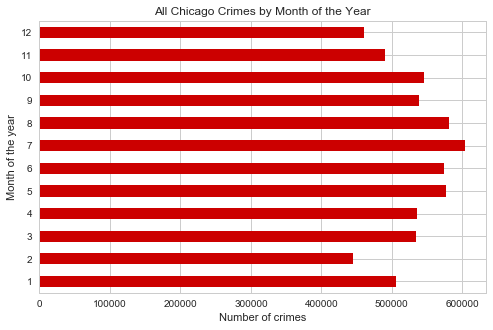

In [11]:
# plot crimes per month of the year
crimes.groupby([crimes.index.month]).size().compute()\
.plot(kind='barh', figsize=(8,5), color='#cc0000')
plt.title('All Chicago Crimes by Month of the Year')
plt.xlabel('Number of crimes')
plt.ylabel('Month of the year')
plt.show()

In [12]:
%%time
print('\nParsing All Crimes...')

# get monthly total crime counts
monthly_crime = crime_types.resample('M').count().compute()

# print monthly total crime stats
print('---------------------------------------')
print(monthly_crime.head())
print('...\nTotal Crime records: {:,}'.format(len(crimes)))
print('Total Months: {:,}'.format(monthly_crime.size))

# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print('\nArrests:')
print('---------------------------------------')
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print('\nDomestic:')
print('---------------------------------------')
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))


Parsing All Crimes...
---------------------------------------
            PrimaryType
2001-01-31        38009
2001-02-28        33711
2001-03-31        40418
2001-04-30        40030
2001-05-31        41734
...
Total Crime records: 6,389,375
Total Months: 200

Arrests:
---------------------------------------
Date
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
Name: Arrest, dtype: bool
...
Total Arrests: 1,793,832

Domestic:
---------------------------------------
Date
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
Name: Domestic, dtype: bool
...
Total Domestic: 830,152
Wall time: 1.23 s


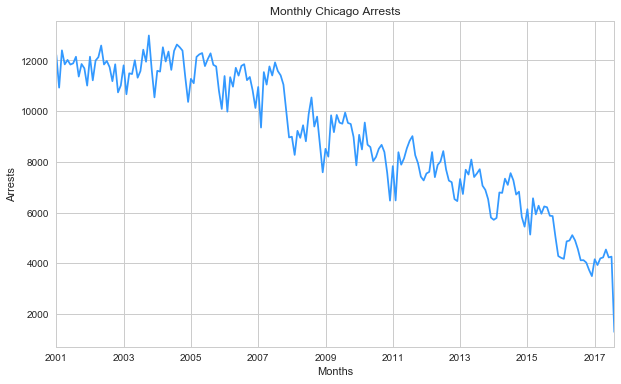

In [13]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(figsize=(10,6), color='#3399ff')
plt.title('Monthly Chicago Arrests')
plt.xlabel('Months')
plt.ylabel('Arrests')
plt.show()

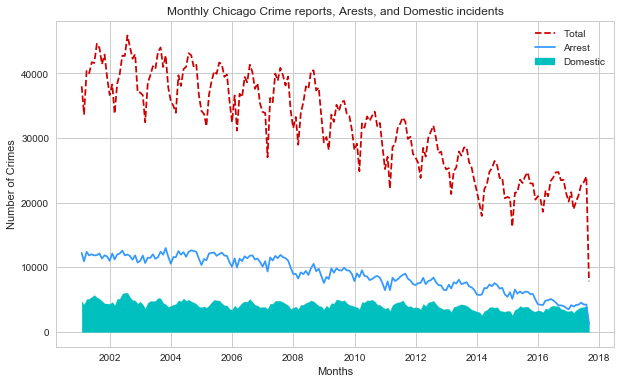

In [14]:
# get monthly domestic crimes
monthly_domestic = domestic.resample('M').sum().compute()

# plot monthly crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_crime.index, monthly_crime, '--', label='Total', color='#cc0000')
ax.plot(monthly_arrests.index, monthly_arrests, color='#3399ff', zorder=10)
ax.fill_between(monthly_domestic.index, monthly_domestic, \
                label='Domestic', color='c')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Crimes')
ax.legend(loc='upper right')
plt.title('Monthly Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

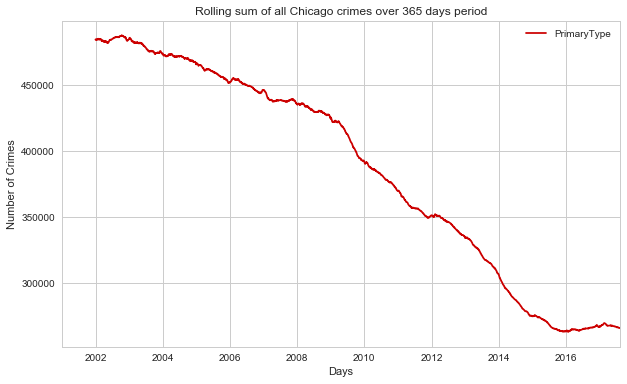

Wall time: 912 ms


In [15]:
%%time
# get crimes rolling sum for a smoother crime decline chart display
crimes_rolling_sum = crime_types.resample('D').count().rolling(365).sum().compute()
crimes_rolling_sum.plot(figsize=(10,6), color='#cc0000')
plt.title('Rolling sum of all Chicago crimes over 365 days period')
plt.xlabel('Days')
plt.ylabel('Number of Crimes')
plt.show()

In [16]:
# get top crime types
top_crime_types = crime_type_counts[crime_type_counts['Total'] >= 200000]\
.sort_values(by='Total', ascending=False)
top_crime_types.head(10)

,Arrest,Domestic,Total
PrimaryType,,,
THEFT,160904.0,30900.0,1333331
BATTERY,267664.0,492971.0,1168774
CRIMINAL DAMAGE,52161.0,55293.0,733734
NARCOTICS,682821.0,245.0,687056
OTHER OFFENSE,70068.0,115322.0,396693
ASSAULT,92488.0,85185.0,392983
BURGLARY,21325.0,2458.0,371699
MOTOR VEHICLE THEFT,27746.0,1136.0,300692
ROBBERY,23622.0,3897.0,242089


In [17]:
%%time
print('Getting Top Crimes by Month...')

# get top crimes stats
# TODO: use isin and index by primary type to speed up this query?
top_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                         (crime_types['PrimaryType']=='BATTERY') | \
                         (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                         (crime_types['PrimaryType']=='NARCOTICS') | \
                         (crime_types['PrimaryType']=='OTHER OFFENSE') | \
                         (crime_types['PrimaryType']=='ASSAULT') | \
                         (crime_types['PrimaryType']=='BURGLARY') | \
                         (crime_types['PrimaryType']=='MOTOR VEHICLE THEFT') | \
                         (crime_types['PrimaryType']=='ROBBERY') | \
                         (crime_types['PrimaryType']=='DECEPTIVE PRACTICE')]
#print(top_crimes.head(10))

# group top crimes by month and crime type
crimes_groupby = top_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
top_crime_data = top_crime_data.unstack()
print(top_crime_data.head(2))
print('...')

Getting Top Crimes by Month...
Date        PrimaryType        
2001-01-31  DECEPTIVE PRACTICE     1383
            THEFT                  7852
            OTHER OFFENSE          2797
            ASSAULT                2122
            CRIMINAL DAMAGE        3960
            BURGLARY               1932
            BATTERY                6520
            MOTOR VEHICLE THEFT    2092
            ROBBERY                1396
            NARCOTICS              4708
Name: Count, dtype: int64
...
PrimaryType  DECEPTIVE PRACTICE  THEFT  OTHER OFFENSE  ASSAULT  \
Date                                                             
2001-01-31                 1383   7852           2797     2122   
2001-02-28                 1155   6660           2485     2028   

PrimaryType  CRIMINAL DAMAGE  BURGLARY  BATTERY  MOTOR VEHICLE THEFT  ROBBERY  \
Date                                                                            
2001-01-31              3960      1932     6520                 2092     1396   

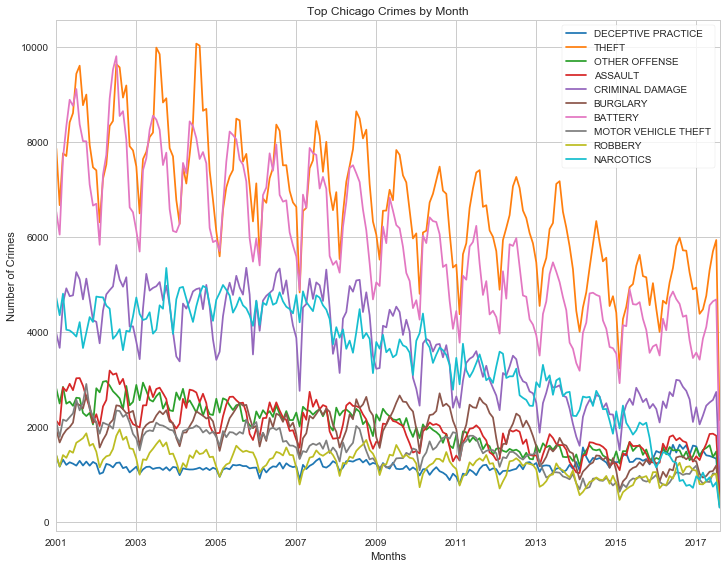

In [18]:
# plot top crimes data by month
top_crime_data.plot(figsize=(10,8), cmap='tab10')
plt.legend(loc='upper right', frameon=True)
plt.title('Top Chicago Crimes by Month')
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
plt.show()

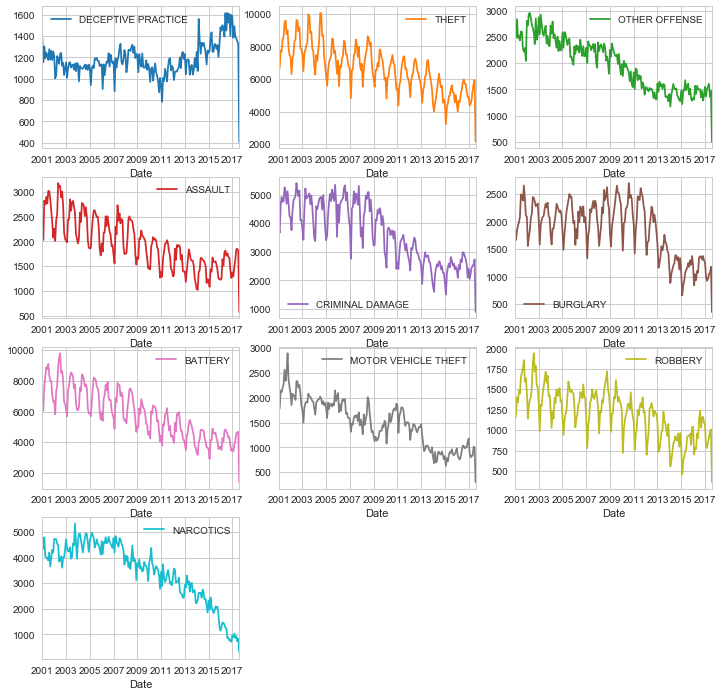

In [19]:
# plot top crimes grid
top_crime_data.plot(figsize=(12, 12), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [20]:
%%time
# get all crime data by month and primary type
crimes_groupby = crime_types.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
all_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(all_crime_data.head(10))
print('...')

# unstack all crimes data for series plotting
all_crime_data = all_crime_data.unstack()
print(all_crime_data.head(2))
print('...')

Date        PrimaryType               
2001-01-31  OFFENSE INVOLVING CHILDREN     239
            DECEPTIVE PRACTICE            1383
            SEX OFFENSE                    185
            THEFT                         7852
            OTHER OFFENSE                 2797
            ASSAULT                       2122
            CRIM SEXUAL ASSAULT            162
            CRIMINAL DAMAGE               3960
            BURGLARY                      1932
            BATTERY                       6520
Name: Count, dtype: int64
...
PrimaryType  OFFENSE INVOLVING CHILDREN  DECEPTIVE PRACTICE  SEX OFFENSE  \
Date                                                                       
2001-01-31                        239.0              1383.0        185.0   
2001-02-28                        151.0              1155.0        149.0   

PrimaryType   THEFT  OTHER OFFENSE  ASSAULT  CRIM SEXUAL ASSAULT  \
Date                                                               
2001-01-31   7852.0 

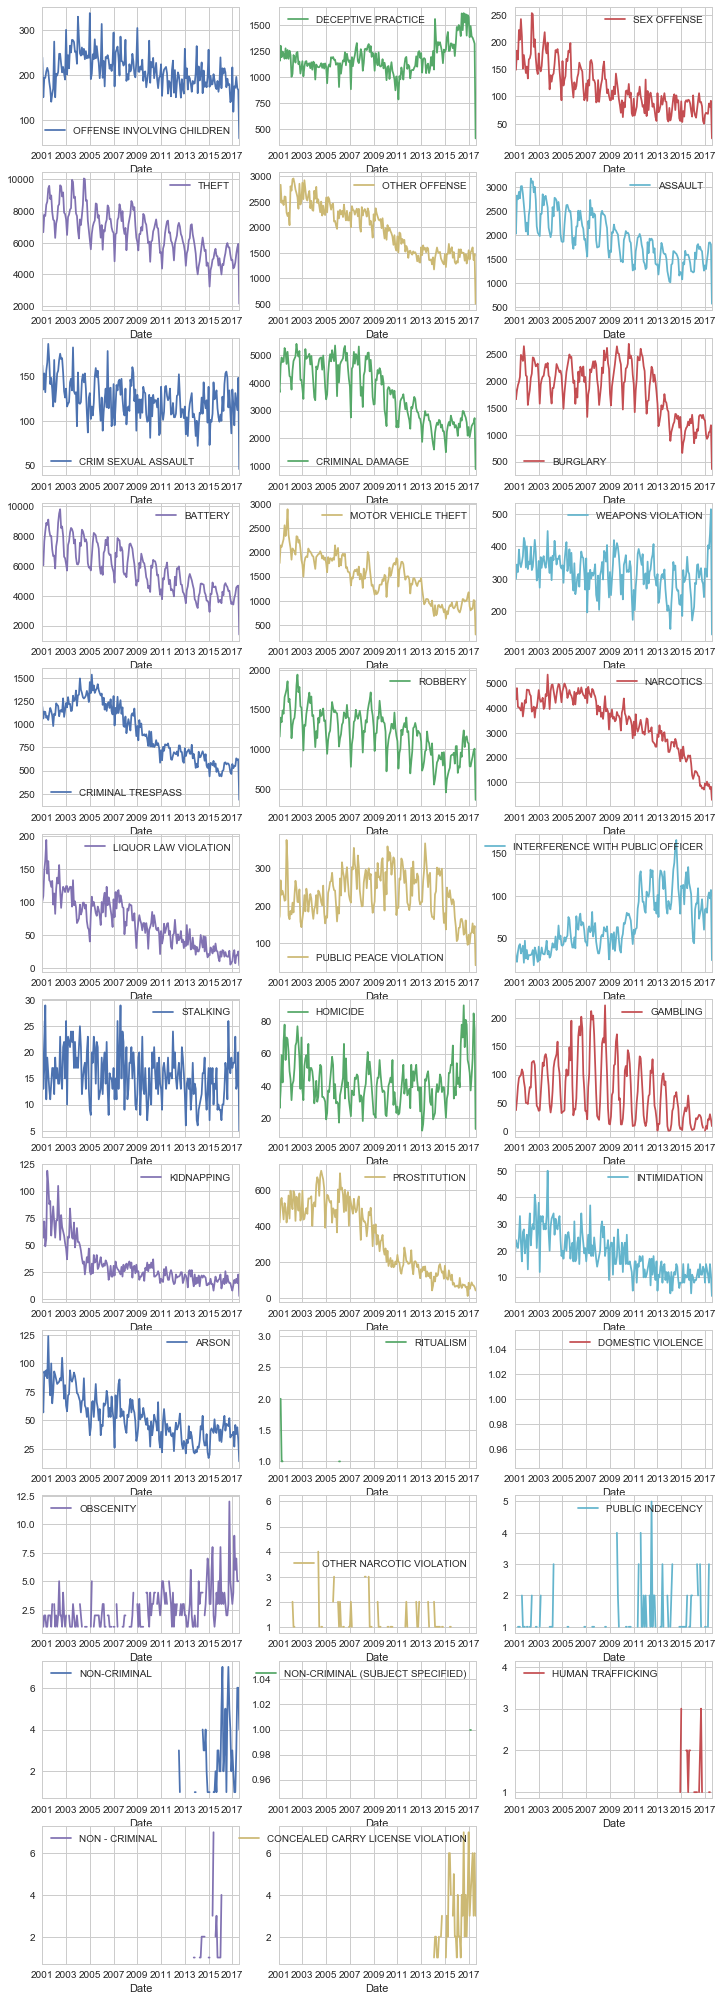

Wall time: 5.19 s


In [21]:
%%time
# plot all crimes over time individually
all_crime_data.plot(figsize=(12, 36), subplots=True, layout=(-1, 3),\
                    sharex=False, sharey=False)
plt.show()

In [22]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       1688402
RESIDENCE    1083741
APARTMENT     653424
SIDEWALK      636726
OTHER         241595
Name: Total, dtype: int64
...
Total Locations: 173


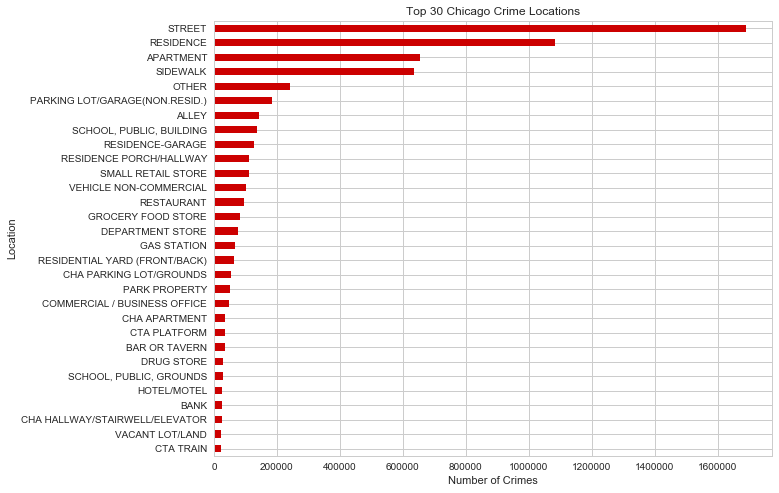

In [23]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True)\
.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('Top 30 Chicago Crime Locations')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
plt.show()

In [24]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName        Side   Total
25             25           Austin   West Side  369987
8               8  Near North Side     Central  191754
43             43      South Shore  South Side  188742
23             23    Humboldt Park   West Side  182862
24             24        West Town   West Side  171530
...
Total Communities: 77


C:\tools\dev\python\Anaconda3\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [25]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,369987
Near North Side,191754
South Shore,188742
Humboldt Park,182862
West Town,171530


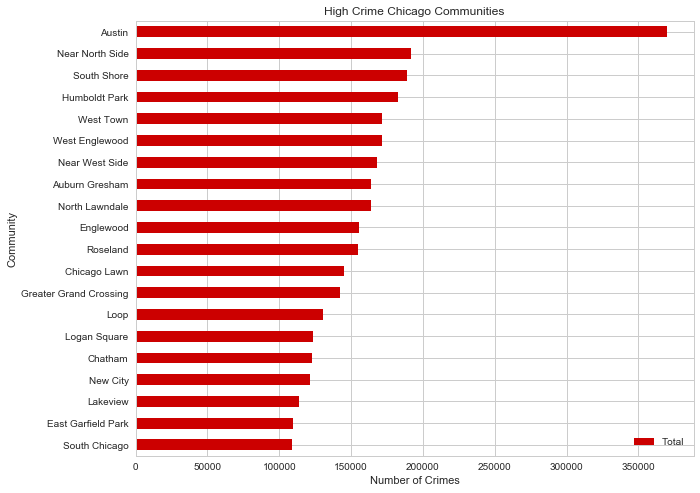

In [26]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('High Crime Chicago Communities')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
plt.show()

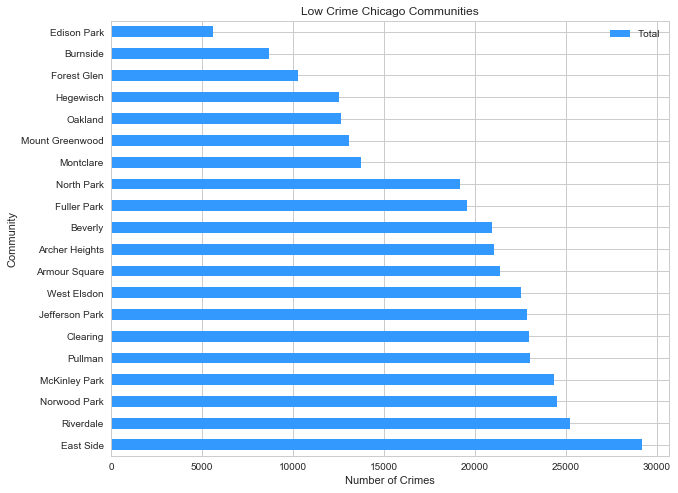

In [27]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False)\
.plot(kind='barh', figsize=(10,8), color='#3399ff')
plt.title('Low Crime Chicago Communities')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
plt.show()

In [28]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum()\
.drop('CommunityArea', axis=1) # denotes column
crime_by_side.sort_values(by='Total', ascending=False)

,Total
Side,
West Side,1425788
Southwest Side,887365
South Side,793512
Far Southeast Side,679149
Far North Side,508294
North Side,416380
Central,366105
Far Southwest Side,365762
Northwest Side,332506


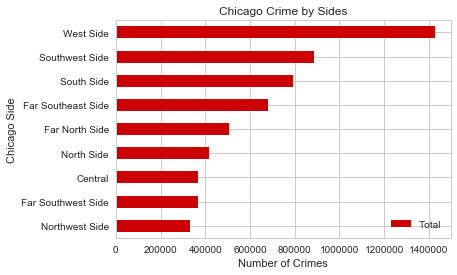

In [29]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4), color='#cc0000')
plt.title('Chicago Crime by Sides')
plt.xlabel('Number of Crimes')
plt.ylabel('Chicago Side')
plt.show()

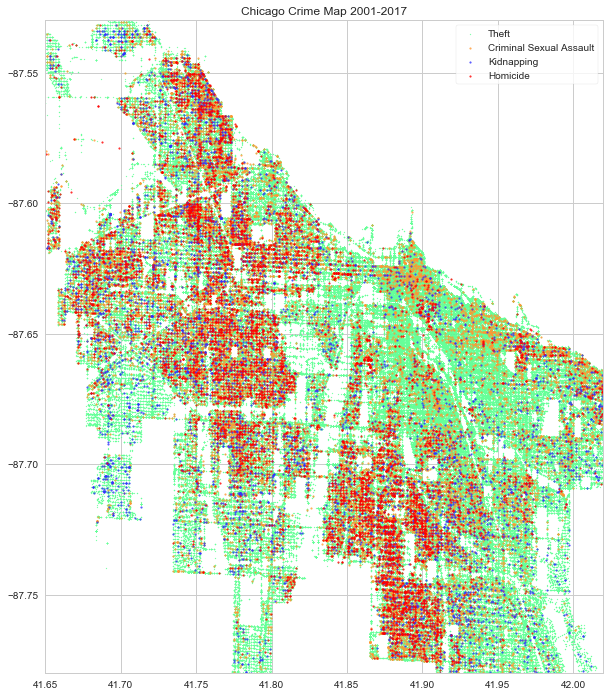

Wall time: 19 s


In [30]:
%%time

# get min/max lat and long
#minLat = crimes['Latitude'].min().compute()
#maxLat = crimes['Latitude'].max().compute()
#minLong = crimes['Longitude'].min().compute()
#maxLong = crimes['Longitude'].max().compute()

# get crime geo data
crime_geo = crimes[['PrimaryType', 'Latitude', 'Longitude']].dropna()

# get homicides
homicides = crime_geo[(crime_geo['PrimaryType']=='HOMICIDE')]\
.compute()

# get kidnappings
kidnappings = crime_geo[(crime_geo['PrimaryType']=='KIDNAPPING')]\
.compute()

# get criminal sexual assaults
sexual_assaults = crime_geo[(crime_geo['PrimaryType']=='CRIM SEXUAL ASSAULT')]\
.compute()

# get thefts
thefts = crime_geo[(crime_geo['PrimaryType']=='THEFT')]\
.compute()

# create scatter map plot
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.65, 42.02) # (minLat, maxLat)
plt.ylim(-87.78, -87.53) # (minLong, maxLong)
#ax.set_facecolor('black')

# plot thefts, homicides, kidnappings and sexual assaults
ax.scatter(thefts['Latitude'], thefts['Longitude'],\
                            s=1, alpha=0.8, color='#66ff99', label='Theft')
ax.scatter(sexual_assaults['Latitude'], sexual_assaults['Longitude'],\
                            s=3, alpha=0.8, color='#ff9933', label='Criminal Sexual Assault')
ax.scatter(kidnappings['Latitude'], kidnappings['Longitude'],\
                            s=3, alpha=0.8, color='#3333ff', label='Kidnapping')
ax.scatter(homicides['Latitude'], homicides['Longitude'],\
                            s=3, alpha=0.8, color='#ff0000', label='Homicide')

plt.title('Chicago Crime Map 2001-2017')
plt.legend(loc='upper right', frameon=True)
plt.show()